In [31]:
import pandas as pd

df = pd.read_csv('../data/dataset-ISTAC-C00022A_000004-~latest-observations.tsv', sep='\t', low_memory = False)

islas = ['Tenerife', 'Gran Canaria', 'Lanzarote', 'Fuerteventura', 'La Palma', 'La Gomera', 'El Hierro'] # 7 main islands
col = ['TERRITORIO', 'TIME_PERIOD_CODE', 'OBS_VALUE', 'FLUJO_ENERGIA'] # important columns

_ = df[df['TERRITORIO'].isin(islas)][col] # take only the 7 main islands
values_islas_total = _[_['FLUJO_ENERGIA'] == 'Inland demand'].drop('FLUJO_ENERGIA', axis=1).reset_index(drop=True) # total demand
values_islas_total['TIME_PERIOD_CODE'] = values_islas_total['TIME_PERIOD_CODE'].astype('datetime64[ns]')

island_demands = {}
for isla in islas:
    island_demands[isla] = (
        values_islas_total[values_islas_total['TERRITORIO'] == isla]
        .drop('TERRITORIO', axis=1)
        .sort_values('TIME_PERIOD_CODE')
        .reset_index(drop=True))

print(_.iloc[13:26])
(_['OBS_VALUE'].iloc[13:25]).sum()

     TERRITORIO TIME_PERIOD_CODE  OBS_VALUE  FLUJO_ENERGIA
1342  Lanzarote         1992-M01       4.92  Inland demand
1343  Lanzarote         1992-M02      -9.02  Inland demand
1344  Lanzarote         1992-M03       7.70  Inland demand
1345  Lanzarote         1992-M04      -4.05  Inland demand
1346  Lanzarote         1992-M05      -1.49  Inland demand
1347  Lanzarote         1992-M06      -2.59  Inland demand
1348  Lanzarote         1992-M07       5.90  Inland demand
1349  Lanzarote         1992-M08       6.74  Inland demand
1350  Lanzarote         1992-M09      -4.28  Inland demand
1351  Lanzarote         1992-M10      -0.19  Inland demand
1352  Lanzarote         1992-M11       1.25  Inland demand
1353  Lanzarote         1992-M12       0.86  Inland demand
1354  Lanzarote             1992      -0.88  Inland demand


5.750000000000001

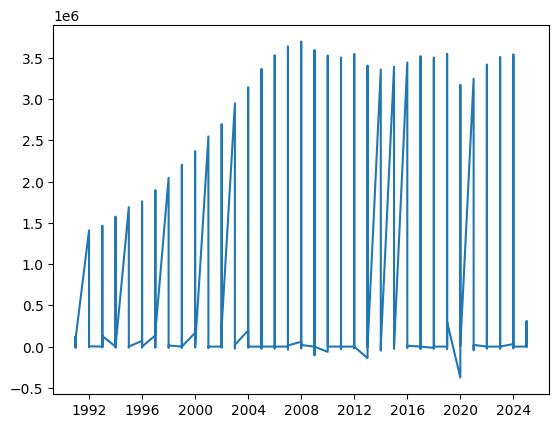

In [22]:
import matplotlib.pyplot as plt

plt.plot(island_demands['Tenerife']['TIME_PERIOD_CODE'], island_demands['Tenerife']['OBS_VALUE'])

In [7]:
import numpy as np
np.linspace(0,30,5)

array([ 0. ,  7.5, 15. , 22.5, 30. ])